<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/singlecomponent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neqsim -q! apt update -q
! apt-get install -q openjdk-25-jdk-headless -q
!pip install neqsim -q
from neqsim import jneqsim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 32.6 MB/s eta 0:00:00


In [ ]:
from neqsim.thermo import fluid, printFrame
from neqsim import jneqsim

# Establish a simple process
The process feeds liquid propane to a separator with gas and liquid outlets. The liquid will flash in the inlet valve to the separator. Furthermore, the liquid propane will flash when further depressurizing.

In [ ]:
fluid1 = fluid('srk')
fluid1.addComponent('propane', 1.0)

stream1 =  jneqsim.process.equipment.stream.Stream('feed stream', fluid1)
stream1.setTemperature(278.15, 'K')
stream1.setPressure(10.0, 'bara')
stream1.setFlowRate(1000.0, 'kg/hr')
stream1.run()
print('feed stream......')
printFrame(stream1.getFluid())

valve1 = jneqsim.process.equipment.valve.ThrottlingValve('control valve 1', stream1)
valve1.setOutletPressure(3.0, 'bara')
valve1.setPercentValveOpening(50)
valve1.run()
print('fluid after control valve 1......')
printFrame(valve1.getOutletStream().getFluid())

separator1 = jneqsim.process.equipment.separator.Separator('separator 1', valve1.getOutletStream())
separator1.setSeparatorLength(2.0);
separator1.setInternalDiameter(1.0);
separator1.run()

gas_valve1 = jneqsim.process.equipment.valve.ThrottlingValve('gas valve 1', separator1.getGasOutStream())
gas_valve1.setOutletPressure(1.4, 'bara')
gas_valve1.setPercentValveOpening(50)
gas_valve1.run()
print('fluid after gas valve from separator......')
printFrame(gas_valve1.getOutletStream().getFluid())

compressor1 = jneqsim.process.equipment.compressor.Compressor('compressor 1', gas_valve1.getOutStream())
compressor1.setOutletPressure(5.0, 'bara')
compressor1.run()
print('fluid after gas compressor......')
printFrame(compressor1.getOutletStream().getFluid())

liquid_valve1 = jneqsim.process.equipment.valve.ThrottlingValve('liq valve 1', separator1.getLiquidOutStream())
liquid_valve1.setOutletPressure(1.4, 'bara')
liquid_valve1.setPercentValveOpening(50)
liquid_valve1.run()
print('fluid after liuqid valve......')
printFrame(liquid_valve1.getOutletStream().getFluid())

process1 = jneqsim.process.processmodel.ProcessSystem('process 1')
process1.add(valve1)
process1.add(separator1)
process1.add(gas_valve1)
process1.add(compressor1)
process1.add(liquid_valve1)
process1.run()


feed stream......
| 0                    | 1          | 2           | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:------------|:----|:----|:----|:----------------|
|                      | total      | OIL         |     |     |     |                 |
| propane              | 1E0        | 1E0         |     |     |     | [mole fraction] |
|                      |            |             |     |     |     |                 |
| Density              |            | 5.16411E2   |     |     |     | kg/m3           |
| Phase Fraction       |            | 1E0         |     |     |     | [mole fraction] |
| Molar Mass           | 4.4097E-2  | 4.4097E-2   |     |     |     | kg/mol          |
| Z factor             |            | 3.69233E-2  |     |     |     | [-]             |
| Heat Capacity (Cp)   |            | 2.63012E0   |     |     |     | kJ/kgK          |
| Heat Capacity (Cv)   |            | 1.74411E0   |     |     |     | kJ/kgK          |
| Speed of Sou

In [ ]:
print('Cv of feed valve ', valve1.getCv('US'))
print('Cv of gas valve ', gas_valve1.getCv('US'))
print('Cv of liquid valve ', liquid_valve1.getCv('US'))

Cv of feed valve  1.2160215634286575
Cv of gas valve  86.85867995496814
Cv of liquid valve  2.169472785569102


# Dynamic calculations
We use the process to simulate dynamic behaviour when changing valve positions og inlet outlet valves.

In [ ]:
valve1.setCalculateSteadyState(False)
separator1.setCalculateSteadyState(False)
gas_valve1.setCalculateSteadyState(False)
liquid_valve1.setCalculateSteadyState(False)

process1.setTimeStep(60.0)

liquid_level_data = []
separator_temperature = []
separator_pressure = []

for i in range(10):
  process1.runTransient()
  liquid_level_data.append(separator1.getLiquidLevel())
  separator_temperature.append(separator1.getFluid().getTemperature('C'))
  separator_pressure.append(separator1.getFluid().getPressure('bara'))


liquid_valve1.setPercentValveOpening(20)

for i in range(10):
  process1.runTransient()
  liquid_level_data.append(separator1.getLiquidLevel())
  separator_temperature.append(separator1.getFluid().getTemperature('C'))
  separator_pressure.append(separator1.getFluid().getPressure('bara'))

valve1.setPercentValveOpening(10)

for i in range(10):
  process1.runTransient()
  liquid_level_data.append(separator1.getLiquidLevel())
  separator_temperature.append(separator1.getFluid().getTemperature('C'))
  separator_pressure.append(separator1.getFluid().getPressure('bara'))

valve1.setPercentValveOpening(50)
liquid_valve1.setPercentValveOpening(50)
gas_valve1.setPercentValveOpening(50)

for i in range(50):
  process1.runTransient()
  liquid_level_data.append(separator1.getLiquidLevel())
  separator_temperature.append(separator1.getFluid().getTemperature('C'))

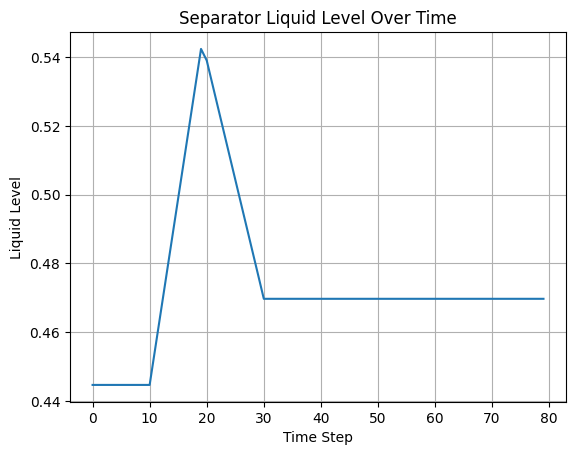

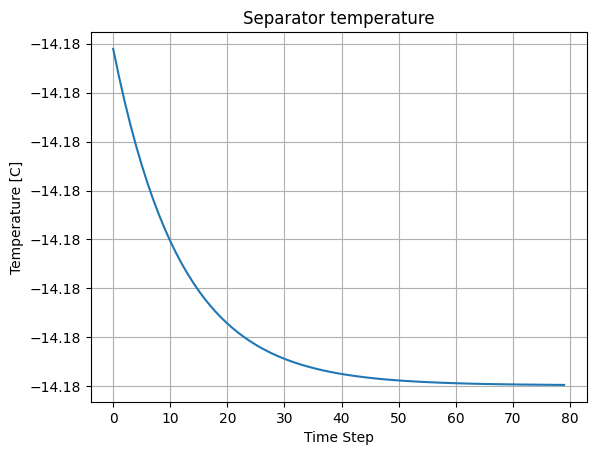

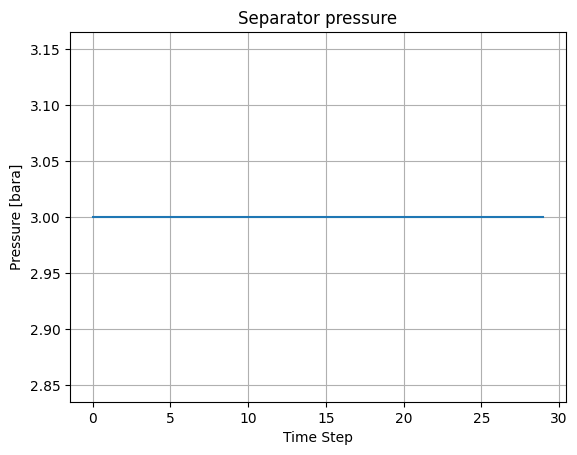

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(liquid_level_data)
plt.xlabel('Time Step')
plt.ylabel('Liquid Level')
plt.title('Separator Liquid Level Over Time')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(separator_temperature)
plt.xlabel('Time Step')
plt.ylabel('Temperature [C]')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
plt.title('Separator temperature')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(separator_pressure)
plt.xlabel('Time Step')
plt.ylabel('Pressure [bara]')
plt.title('Separator pressure')
plt.grid(True)
plt.show()

# Single component flash routines

Demonstration of a phase fraction temperature and pressure flash

In [ ]:
fluid2 = fluid('srk')
fluid2.addComponent('propane', 1.0)
fluid2.setTemperature(-20.0, 'C')
fluid2.setPressure(10.0, 'bara')

flash = jneqsim.thermodynamicoperations.ThermodynamicOperations(fluid2)
flash.TPflash()

flash.constantPhaseFractionPressureFlash(0.5)
printFrame(fluid2)

flash.constantPhaseFractionTemperatureFlash(0.5)
printFrame(fluid2)




| 0                    | 1          | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total      | GAS                | OIL                |     |     |                 |
| propane              | 1E0        | 1E0                | 1E0                |     |     | [mole fraction] |
|                      |            |                    |                    |     |     |                 |
| Density              |            | 5.45543E0          | 5.55723E2          |     |     | kg/m3           |
| Phase Fraction       |            | 5E-1               | 5E-1               |     |     | [mole fraction] |
| Molar Mass           | 4.4097E-2  | 4.4097E-2          | 4.4097E-2          |     |     | kg/mol          |
| Z factor             |            | 9.37213E-1         | 9.20044E-3         |     |     | [-]             |
| Heat Cap

Demo of a TP, PH flash and saturation calculations

In [ ]:

fluid1 = fluid('srk')
fluid1.addComponent('propane', 1.0)
fluid1.setTemperature(278.15, 'K')
fluid1.setPressure(10.0, 'bara')

flash = jneqsim.thermodynamicoperations.ThermodynamicOperations(fluid1)
flash.TPflash()
printFrame(fluid1)

fluid1.initProperties()
enthalpy = fluid1.getEnthalpy()
energy = fluid1.getInternalEnergy()
volume = fluid1.getVolume()
print(enthalpy)

fluid1.setPressure(3.0)

flash.PHflash(enthalpy)
printFrame(fluid1)


from neqsim.thermo import bubp,bubt, dewp, dewt

dewt(fluid1)
print('dew point temperature ' , fluid1.getTemperature('C') )
printFrame(fluid1)


| 0                    | 1          | 2           | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:------------|:----|:----|:----|:----------------|
|                      | total      | OIL         |     |     |     |                 |
| propane              | 1E0        | 1E0         |     |     |     | [mole fraction] |
|                      |            |             |     |     |     |                 |
| Density              |            | 5.16411E2   |     |     |     | kg/m3           |
| Phase Fraction       |            | 1E0         |     |     |     | [mole fraction] |
| Molar Mass           | 4.4097E-2  | 4.4097E-2   |     |     |     | kg/mol          |
| Z factor             |            | 3.69233E-2  |     |     |     | [-]             |
| Heat Capacity (Cp)   |            | 2.63012E0   |     |     |     | kJ/kgK          |
| Heat Capacity (Cv)   |            | 1.74411E0   |     |     |     | kJ/kgK          |
| Speed of Sound       |        

# Gas depressurization
In the following example we will simulate the feed of hydrogen to a separator and further depressurization of the gas from the separator.

In [ ]:
fluid1 = fluid('srk')
fluid1.addComponent('hydrogen', 1.0)

stream1 =  jneqsim.process.equipment.stream.Stream('feed stream', fluid1)
stream1.setTemperature(278.15, 'K')
stream1.setPressure(10.0, 'bara')
stream1.setFlowRate(100.0, 'kg/hr')
stream1.run()
print('feed stream......')
printFrame(stream1.getFluid())

valve1 = jneqsim.process.equipment.valve.ThrottlingValve('control valve 1', stream1)
valve1.setOutletPressure(3.0, 'bara')
valve1.run()
valve1.getFluid().initProperties()
print('downstream feed valve......')
printFrame(valve1.getOutletStream().getFluid())

separator1 = jneqsim.process.equipment.separator.Separator('separator 1', valve1.getOutletStream())
separator1.setSeparatorLength(4.0);
separator1.setInternalDiameter(2.0);
separator1.setLiquidLevel(0.000001)
separator1.run()

gas_valve1 = jneqsim.process.equipment.valve.ThrottlingValve('gas valve 1', separator1.getGasOutStream())
gas_valve1.setOutletPressure(1.01325, 'bara')
gas_valve1.run()
print('outlet gas valve......')
printFrame(gas_valve1.getOutletStream().getFluid())

compressor1 = jneqsim.process.equipment.compressor.Compressor('compressor 1', gas_valve1.getOutStream())
compressor1.setOutletPressure(5.0, 'bara')
compressor1.run()
print('outlet compressor......')
printFrame(compressor1.getOutletStream().getFluid())

liquid_valve1 = jneqsim.process.equipment.valve.ThrottlingValve('liq valve 1', separator1.getLiquidOutStream())
liquid_valve1.setOutletPressure(1.01325, 'bara')
liquid_valve1.run()
print('outlet liquid valve......')
printFrame(liquid_valve1.getOutletStream().getFluid())

process1 = jneqsim.process.processmodel.ProcessSystem('process 1')
process1.add(valve1)
process1.add(separator1)
process1.add(gas_valve1)
process1.add(compressor1)
process1.add(liquid_valve1)
process1.run()

valve1.setCalculateSteadyState(False)
separator1.setCalculateSteadyState(False)
gas_valve1.setCalculateSteadyState(False)
liquid_valve1.setCalculateSteadyState(False)

process1.setTimeStep(1.0)

flow_rate = []
liquid_level_data = []
separator_temperature = []
separator_pressure = []

for i in range(50):
  process1.runTransient()
  flow_rate.append(gas_valve1.getOutletStream().getFlowRate('kg/hr'))
  liquid_level_data.append(separator1.getLiquidLevel())
  separator_temperature.append(separator1.getFluid().getTemperature('C'))
  separator_pressure.append(separator1.getFluid().getPressure('bara'))


valve1.setPercentValveOpening(0.1)

for i in range(200):
  process1.runTransient()
  flow_rate.append(gas_valve1.getOutletStream().getFlowRate('kg/hr'))
  liquid_level_data.append(separator1.getLiquidLevel())
  separator_temperature.append(separator1.getFluid().getTemperature('C'))
  separator_pressure.append(separator1.getFluid().getPressure('bara'))


feed stream......
| 0                    | 1          | 2           | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:------------|:----|:----|:----|:----------------|
|                      | total      | GAS         |     |     |     |                 |
| hydrogen             | 1E0        | 1E0         |     |     |     | [mole fraction] |
|                      |            |             |     |     |     |                 |
| Density              |            | 8.66627E-1  |     |     |     | kg/m3           |
| Phase Fraction       |            | 1E0         |     |     |     | [mole fraction] |
| Molar Mass           | 2.016E-3   | 2.016E-3    |     |     |     | kg/mol          |
| Z factor             |            | 1.00588E0   |     |     |     | [-]             |
| Heat Capacity (Cp)   |            | 1.42421E1   |     |     |     | kJ/kgK          |
| Heat Capacity (Cv)   |            | 1.00854E1   |     |     |     | kJ/kgK          |
| Speed of Sou

In [ ]:
print('Cv of feed valve ', valve1.getCv('US'))
print('Cv of gas valve ', gas_valve1.getCv('US'))

Cv of feed valve  46.93456836946276
Cv of gas valve  160.53719807318555


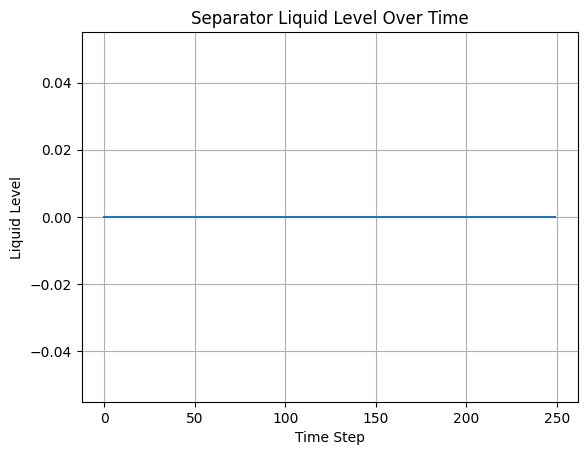

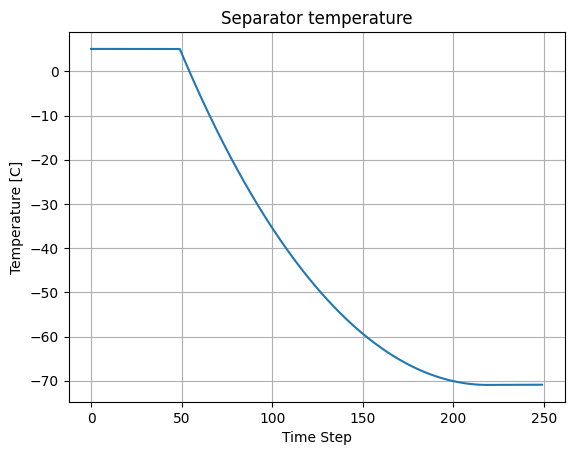

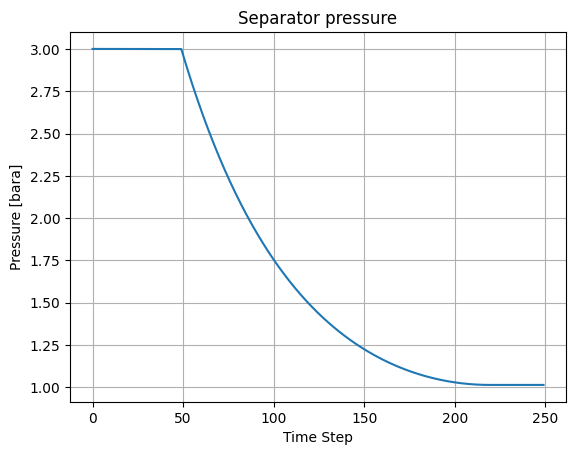

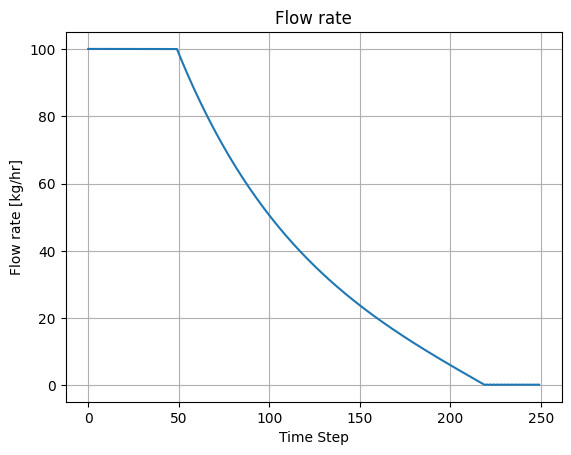

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(liquid_level_data)
plt.xlabel('Time Step')
plt.ylabel('Liquid Level')
plt.title('Separator Liquid Level Over Time')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(separator_temperature)
plt.xlabel('Time Step')
plt.ylabel('Temperature [C]')
plt.title('Separator temperature')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(separator_pressure)
plt.xlabel('Time Step')
plt.ylabel('Pressure [bara]')
plt.title('Separator pressure')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(flow_rate)
plt.xlabel('Time Step')
plt.ylabel('Flow rate [kg/hr]')
plt.title('Flow rate')
plt.grid(True)
plt.show()

# Set quality spec of a stream

In the following examples we specify different quality of the feed stream.

In [ ]:
fluid1 = fluid('srk')
fluid1.addComponent('propane', 1.0)

stream1 =  jneqsim.process.equipment.stream.Stream('feed stream', fluid1)
stream1.setSpecification('gas quality')
stream1.setPressure(10.0, 'bara')
stream1.setGasQuality(0.1)
stream1.setFlowRate(1000.0, 'kg/hr')
stream1.run()
print('feed stream......')
printFrame(stream1.getFluid())

# setting bubble point pressure specification
stream1 =  jneqsim.process.equipment.stream.Stream('feed stream', fluid1)
stream1.setSpecification('bubP')
stream1.setPressure(1.0, 'bara')
stream1.setFlowRate(1000.0, 'kg/hr')
stream1.run()
print('feed stream......')
printFrame(stream1.getFluid())

# setting dew point pressure specification
stream1 =  jneqsim.process.equipment.stream.Stream('feed stream', fluid1)
stream1.setSpecification('dewP')
stream1.setPressure(5.0, 'bara')
stream1.setFlowRate(1000.0, 'kg/hr')
stream1.run()
print('feed stream......')
printFrame(stream1.getFluid())


feed stream......
| 0                    | 1          | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total      | GAS                | OIL                |     |     |                 |
| propane              | 1E0        | 1E0                | 1E0                |     |     | [mole fraction] |
|                      |            |                    |                    |     |     |                 |
| Density              |            | 2.15243E1          | 4.73051E2          |     |     | kg/m3           |
| Phase Fraction       |            | 1E-1               | 9E-1               |     |     | [mole fraction] |
| Molar Mass           | 4.4097E-2  | 4.4097E-2          | 4.4097E-2          |     |     | kg/mol          |
| Z factor             |            | 8.22304E-1         | 3.74156E-2         |     |     | [-]       